# How to Grid Search ARIMA Model Hyperparameters with Python
The ARIMA model for time series analysis and forecasting can be tricky to configure.

There are 3 parameters that require estimation by iterative trial and error from reviewing diagnostic plots and using 40-year-old heuristic rules.

We can automate the process of evaluating a large number of hyperparameters for the ARIMA model by using a grid search procedure.

In this tutorial, you will discover how to tune the ARIMA model using a grid search of hyperparameters in Python.

After completing this tutorial, you will know:

* A general procedure that you can use to tune the ARIMA hyperparameters for a rolling one-step forecast.
* How to apply ARIMA hyperparameter optimization on a standard univariate time series dataset.
* Ideas for extending the procedure for more elaborate and robust models.

Let’s get started.

## Grid Searching Method
Diagnostic plots of the time series can be used along with heuristic rules to determine the hyperparameters of the ARIMA model.

These are good in most, but perhaps not all, situations.

We can automate the process of training and evaluating ARIMA models on different combinations of model hyperparameters. In machine learning this is called a grid search or model tuning.

In this tutorial, we will develop a method to grid search ARIMA hyperparameters for a one-step rolling forecast.

The approach is broken down into two parts:

1. Evaluate an ARIMA model.
2. Evaluate sets of ARIMA parameters.

The code in this tutorial makes use of the scikit-learn, Pandas, and the statsmodels Python libraries.

### 1. Evaluate ARIMA Model
We can evaluate an ARIMA model by preparing it on a training dataset and evaluating predictions on a test dataset.

This approach involves the following steps:

1. Split the dataset into training and test sets.
2. Walk the time steps in the test dataset: (1) Train an ARIMA model, (2) Make a one-step prediction, (3) Store prediction; get and store actual observation.
3. Calculate error score for predictions compared to expected values.

We can implement this in Python as a new standalone function called evaluate_arima_model() that takes a time series dataset as input as well as a tuple with the p, d, and q parameters for the model to be evaluated.

The dataset is split in two: 66% for the initial training dataset and the remaining 34% for the test dataset.

Each time step of the test set is iterated. Just one iteration provides a model that you could use to make predictions on new data. The iterative approach allows a new ARIMA model to be trained each time step.

A prediction is made each iteration and stored in a list. This is so that at the end of the test set, all predictions can be compared to the list of expected values and an error score calculated. In this case, a mean squared error score is calculated and returned.

The complete function is listed below.

In [1]:
# load dataset
import os
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/users/akuppam/documents/Data/RoverData/rnbl2agg.csv")
df.head(5)
#def parser(x):
#	return datetime.strptime('190'+x, '%Y-%m')
#series = read_csv('*.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

,date,region,marketing,visits,br,inq,gb,cb,nb,ss,ts,listings
0,2016-01-01,all,all,2293712,8845,118349,8205,698,7507,6.740627e+05,191935.4706,28296771
1,2016-01-02,all,all,2620436,10255,142797,10094,838,9256,7.939500e+05,248524.9014,28205540
2,2016-01-03,all,all,3186849,12837,184483,12351,890,11461,7.694853e+05,299503.2650,28194192
3,2016-01-04,all,all,3317763,13517,188283,14251,1415,12836,1.711552e+06,339585.2933,28349902
4,2016-01-05,all,all,3267402,14318,194315,15468,1584,13884,1.814768e+06,368632.8372,28373795


In [ ]:
df.loc[(df['column_name'] == some_value) & df['other_column'].isin(some_values)]

In [1]:
# load dataset
import os
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/users/akuppam/documents/Hprog/R/Prophet/rnb1015.csv")
df.head(5)

,date,region,marketing,visits,br,inq,gb,cb,nb,ss,ts,listings
0,1/1/16,AMR,NotPaid,1256288,6043,66022,6071,571,5500,485968.08000,144695.894200,10242216
1,1/1/16,AMR,Paid,189297,1092,11806,743,2,741,0.00000,14138.809600,2133795
2,1/1/16,UK,NotPaid,201797,435,9662,436,33,403,72698.92472,8317.105056,3561696
3,1/1/16,UK,Paid,55934,88,2749,61,1,60,0.00000,815.336426,890424
4,1/1/16,CE,NotPaid,200786,573,9250,435,31,404,40490.73159,12016.782410,3062480


In [ ]:
df.loc[(df['column_name'] == some_value) & df['other_column'].isin(some_values)]

In [3]:
df_SoEu = df.loc[(df['region'] == 'SoEu') & (df['marketing'] == 'Paid')]

In [2]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.80)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

Now that we know how to evaluate one set of ARIMA hyperparameters, let’s see how we can call this function repeatedly for a grid of parameters to evaluate.

### 2. Iterate ARIMA Parameters
Evaluating a suite of parameters is relatively straightforward.

The user must specify a grid of p, d, and q ARIMA parameters to iterate. A model is created for each parameter and its performance evaluated by calling the evaluate_arima_model() function described in the previous section.

The function must keep track of the lowest error score observed and the configuration that caused it. This can be summarized at the end of the function with a print to standard out.

We can implement this function called evaluate_models() as a series of four loops.

There are two additional considerations. The first is to ensure the input data are floating point values (as opposed to integers or strings), as this can cause the ARIMA procedure to fail.

Second, the statsmodels ARIMA procedure internally uses numerical optimization procedures to find a set of coefficients for the model. These procedures can fail, which in turn can throw an exception. We must catch these exceptions and skip those configurations that cause a problem. This happens more often then you would think.

Additionally, it is recommended that warnings be ignored for this code to avoid a lot of noise from running the procedure. This can be done as follows:

In [3]:
import warnings
warnings.filterwarnings("ignore")

The complete procedure for evaluating a grid of ARIMA hyperparameters is listed below.

In [4]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

Once loaded, we can specify a site of p, d, and q values to search and pass them to the evaluate_models() function.

We will try a suite of lag values (p) and just a few difference iterations (d) and residual error lag values (q).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 12 columns):
date         998 non-null object
region       998 non-null object
marketing    998 non-null object
visits       998 non-null int64
br           998 non-null int64
inq          998 non-null int64
gb           998 non-null int64
cb           998 non-null int64
nb           998 non-null int64
ss           998 non-null float64
ts           998 non-null float64
listings     998 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 93.6+ KB


In [8]:
# evaluate parameters
# p_values = [0, 1, 2, 4, 6, 8, 10]
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df.nb, p_values, d_values, q_values)

Best ARIMANone MSE=inf


Putting this all together with the generic procedures defined in the previous section, we can grid search ARIMA hyperparameters.

The complete code example is listed below.

ARIMA(0, 0, 0) MSE=0.230
Best ARIMA(0, 0, 0) MSE=0.230


NameError: name 'predictions' is not defined

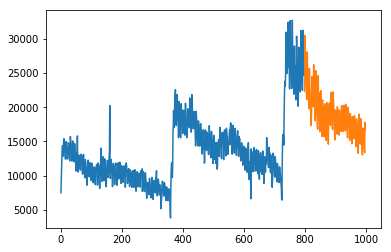

In [37]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.80)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
#	error = mean_squared_error(test, predictions)
	mape = np.mean(abs((test-predictions)/test))
	return mape
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.6f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

 
# load dataset
#def parser(x):
#	return datetime.strptime('190'+x, '%Y-%m')
#series = read_csv('*.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = df['nb']
# evaluate parameters
#p_values = [0, 1, 2, 4, 6, 8, 10]
p_values = range(0, 1)
d_values = range(0, 1)
q_values = range(0, 1)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


In [24]:
import numpy as np


In [ ]:
ARIMA(0, 0, 0) MSE=0.230
ARIMA(0, 0, 1) MSE=0.166
ARIMA(0, 0, 2) MSE=0.162
ARIMA(0, 1, 0) MSE=0.171
ARIMA(0, 1, 1) MSE=0.170
ARIMA(0, 1, 2) MSE=0.162
ARIMA(0, 2, 0) MSE=0.207
ARIMA(0, 2, 1) MSE=0.172
ARIMA(0, 2, 2) MSE=0.171
ARIMA(1, 0, 0) MSE=0.165
ARIMA(1, 0, 1) MSE=0.165
ARIMA(1, 0, 2) MSE=0.161
ARIMA(1, 1, 0) MSE=0.171
ARIMA(1, 1, 1) MSE=0.163
ARIMA(1, 1, 2) MSE=0.164
ARIMA(1, 2, 0) MSE=0.201
ARIMA(2, 0, 0) MSE=0.165
ARIMA(2, 0, 1) MSE=0.161
ARIMA(2, 0, 2) MSE=0.161
ARIMA(2, 1, 0) MSE=0.167
ARIMA(2, 1, 1) MSE=0.163
ARIMA(2, 1, 2) MSE=0.165
ARIMA(2, 2, 0) MSE=0.193
ARIMA(2, 2, 2) MSE=0.164
Best ARIMA(1, 0, 2) MSE=0.161

In [ ]:
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
 
# plot predictions and expected results
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

### Visual of 'train' vs 'test'

Observations: 998
Training Observations: 798
Testing Observations: 200


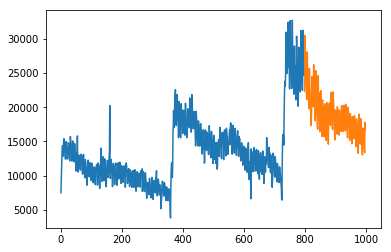

In [17]:
from pandas import Series
from matplotlib import pyplot
series = df['nb']
X = series.values
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()

### ARIMA model diagnostics

In [18]:
import statsmodels.api as sm

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [38]:
model = ARIMA(df['nb'], order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.nb   No. Observations:                  997
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8683.939
Method:                       css-mle   S.D. of innovations           1465.952
Date:                Mon, 08 Oct 2018   AIC                          17379.879
Time:                        15:57:54   BIC                          17409.307
Sample:                             1   HQIC                         17391.065
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3134     24.505      0.258      0.797     -41.715      54.341
ar.L1.D.nb     1.1776      0.022     53.612      0.000       1.135       1.221
ar.L2.D.nb    -0.8309      0.026    -32.448      0.0

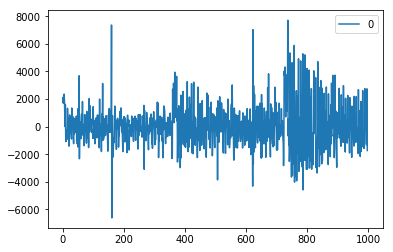

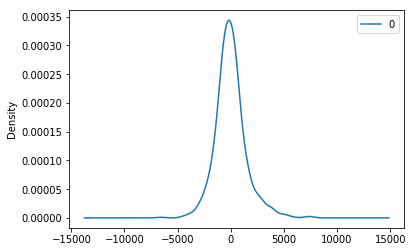

                 0
count   997.000000
mean      2.832127
std    1468.426097
min   -6610.515698
25%    -807.043086
50%     -96.835973
75%     659.607629
max    7709.086948


In [39]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

### Apply grid-searched (or estimated) model
#### Plot 'real' vs. 'predictions'

Test MSE: 3432713.836
MAPE: 0.160575


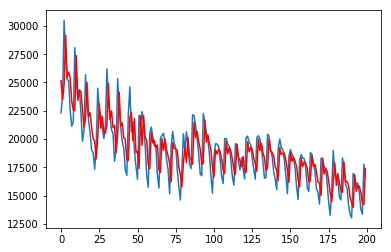

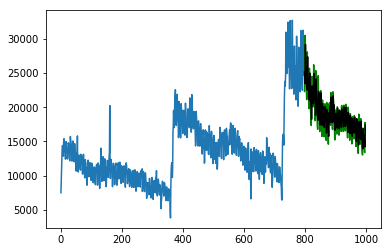

In [50]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
#	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
mape = np.mean(abs((test-predictions)/test))
print('Test MSE: %.3f' % error)
print('MAPE: %.6f' % mape)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
#pyplot.plot(train)
#pyplot.plot(predictions, color='black')
#pyplot.show()
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test], color='green')
pyplot.plot([None for i in train] + [x for x in predictions], color='black')
pyplot.show()
pdf = pd.DataFrame(predictions)
pdf.to_csv("predictions_arima_agg.csv")

In [ ]:
# re-do grid search with the WHOLE dataset, rather than train/test
# re-compute MSE and MAPE, and plot
# output predictionsAll

### Grid-search ARIMA parameters on 'all' data

In [4]:
df_SoEu.describe()

,visits,br,inq,gb,cb,nb,ss,ts,listings
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1.019000e+03
mean,75323.031403,127.437684,1870.481845,71.300294,10.877331,60.422964,274.992046,4891.324946,1.258473e+06
std,30668.661438,59.993490,1373.247034,33.129444,8.420766,28.531110,611.260040,3749.940108,2.592105e+05
min,13699.000000,12.000000,227.000000,7.000000,0.000000,-55.000000,0.000000,-13107.894210,1.688280e+05
25%,54087.000000,77.000000,769.500000,43.500000,5.000000,38.000000,0.000000,1778.225913,1.116910e+06
50%,71396.000000,126.000000,1305.000000,71.000000,10.000000,60.000000,0.000000,3805.584926,1.294740e+06
75%,93718.500000,171.500000,2777.000000,97.000000,15.000000,81.000000,0.000000,7491.486037,1.429740e+06
max,189138.000000,340.000000,7011.000000,168.000000,145.000000,148.000000,5274.656665,18210.860160,1.710540e+06


In [77]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	history = [x for x in X]
	# make predictions
	predictions = list()
	for t in range(len(X)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(X[t])
	# calculate out of sample error
	error = mean_squared_error(X, predictions)
#	mape = np.mean(abs((X-predictions)/X))
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA %s MSE=%.3f' % (order,mse))
				except:
					continue
#	print('arima order is ARIMA%s' % (order))
	print('Best ARIMA %s MSE=%.3f' % (best_cfg, best_score))
	print(best_cfg)
#	arorder = best_cfg
#	print('arima order is%s' % (best_cfg))
#	return best_cfg

# load dataset
series = df_SoEu['nb']

# evaluate parameters
#p_values = [0, 1, 2, 4, 6, 8, 10]
p_values = range(0, 1)
d_values = range(0, 1)
q_values = range(0, 1)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

p = arima_order[0]
d = order[1]
q = order[2]

# apply model
model = ARIMA(df_SoEu['nb'], order=(p,d,q))

ARIMA (0, 0, 0) MSE=813.751
Best ARIMA (0, 0, 0) MSE=813.751
(0, 0, 0)


NameError: name 'arima_order' is not defined

In [ ]:
# apply model
model = ARIMA(df_SoEu['nb'], order=(best))

In [58]:
arima_order

NameError: name 'arima_order' is not defined

In [33]:
return arorder

SyntaxError: 'return' outside function (<ipython-input-33-c933db50d54e>, line 1)

In [24]:
order

NameError: name 'order' is not defined

In [26]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(df_SoEu['nb'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_SoEu['nb'])

ModuleNotFoundError: No module named 'pyramid.arima'

In [ ]:
'''
Arima grid search results from "SoEu_Paid"

ARIMA(0, 0, 0) MSE=813.751
ARIMA(0, 0, 1) MSE=451.074
ARIMA(0, 0, 2) MSE=357.223
ARIMA(0, 1, 0) MSE=279.477
ARIMA(0, 1, 1) MSE=225.589
ARIMA(0, 1, 2) MSE=218.031
ARIMA(0, 2, 0) MSE=737.381
ARIMA(0, 2, 1) MSE=279.914
ARIMA(1, 0, 0) MSE=255.719
ARIMA(1, 0, 1) MSE=223.124
ARIMA(1, 0, 2) MSE=216.246
ARIMA(1, 1, 0) MSE=251.546
ARIMA(1, 1, 1) MSE=218.307
ARIMA(1, 1, 2) MSE=218.154
ARIMA(1, 2, 0) MSE=489.213
ARIMA(2, 0, 0) MSE=239.508
ARIMA(2, 0, 1) MSE=216.574
ARIMA(2, 0, 2) MSE=216.382
ARIMA(2, 1, 0) MSE=238.593
ARIMA(2, 1, 1) MSE=217.999
ARIMA(2, 1, 2) MSE=212.974
ARIMA(2, 2, 0) MSE=402.461
Best ARIMA(2, 1, 2) MSE=212.974
'''


In [ ]:
''' Results from the above block of code
ARIMA(0, 0, 0) MSE=25348127.778
ARIMA(0, 0, 1) MSE=9310570.488
ARIMA(0, 0, 2) MSE=5821136.980
ARIMA(0, 1, 0) MSE=3240352.493
ARIMA(0, 1, 1) MSE=3244904.813
ARIMA(0, 1, 2) MSE=2699074.874
ARIMA(0, 2, 0) MSE=6643956.185
ARIMA(0, 2, 1) MSE=3246630.829
ARIMA(0, 2, 2) MSE=3251389.149
ARIMA(1, 0, 0) MSE=3140615.169
ARIMA(1, 0, 1) MSE=3146064.663
ARIMA(1, 0, 2) MSE=2691424.750
ARIMA(1, 1, 0) MSE=3242570.123
ARIMA(1, 1, 1) MSE=2854332.273
ARIMA(1, 1, 2) MSE=2681621.464
ARIMA(1, 2, 0) MSE=5688464.888
ARIMA(2, 0, 0) MSE=3143192.303
ARIMA(2, 0, 1) MSE=2846138.224
ARIMA(2, 0, 2) MSE=2674259.089
ARIMA(2, 1, 0) MSE=3009150.366
ARIMA(2, 1, 1) MSE=2613145.196
ARIMA(2, 1, 2) MSE=2236334.990
ARIMA(2, 2, 0) MSE=4878185.323
Best ARIMA(2, 1, 2) MSE=2236334.990
'''

In [71]:
# https://github.com/MaxBenChrist/awesome_time_series_in_python

import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#data = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv')
#data.index = data['time'].values

#plt.figure(figsize=(15,5))
#plt.plot(data.index,data['sunspot.year'])
#plt.ylabel('Sunspots')
#plt.title('Yearly Sunspot Data');

In [ ]:
model = pf.ARIMA(data=data, ar=4, ma=4, target='sunspot.year', family=pf.Normal())

In [72]:
model = pf.ARIMA(data=df_SoEu, ar=4, ma=4, target='nb', family=pf.Normal())

In [73]:
x = model.fit("MLE")
x.summary()

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: nb                                  Method: MLE                                       
Start Date: 47                                          Log Likelihood: -4133.8524                        
End Date: 10187                                         AIC: 8287.7048                                    
Number of observations: 1015                            BIC: 8336.9312                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 1.6632     0.7965     2.0881   0.0368   (0.102 | 3.2243)         
AR(1)                                

### Apply grid-searched (or estimated) model - to 'ALL' data

In [9]:
# load dataset
series = df_SoEu['nb']
X = series.values
history = [x for x in X]
predictions = list()
for t in range(len(X)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = X[t]
	history.append(obs)
	abspctdiff = abs((X[t]-predictions[t])/X[t])
#	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(X, predictions)
import numpy as np
mape = np.mean(abspctdiff)
print('Test MSE: %.3f' % error)
print('MAPE: %.6f' % mape)

'''
Results w/ diff ARIMA orders
ARIMA(2,1,2)
Test MSE: 212.974
MAPE: 0.349913

ARIMA(1,1,1)
Test MSE: 218.307
MAPE: 0.301372
'''

Test MSE: 218.307
MAPE: 0.301372


'\nResults w/ diff ARIMA orders\nARIMA(2,1,2)\nTest MSE: 212.974\nMAPE: 0.349913\n\nARIMA(1,1,1)\n\n'

### Output 'predictions' and plot against 'real'

In [6]:
pdf = pd.DataFrame(predictions)
pdf.to_csv("predictions_All_arima_agg1.csv")

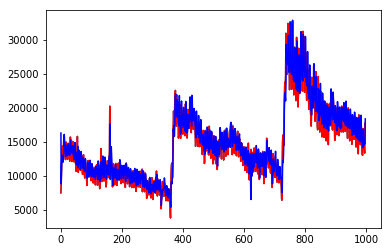

In [9]:
from matplotlib import pyplot
pyplot.plot(X)
pyplot.plot([x for x in X], color='red')
pyplot.plot([x for x in predictions], color='blue')
pyplot.show()

### Forecast 4 months into the future

In [57]:
# Get forecast 120 steps ahead in future
pred_forecast = model_fit.forecast(steps=120)


In [60]:
pred_forecast

(array([18384.79732762, 17557.21042254, 16079.47993451, 15034.59429342,
        15040.31017026, 15920.2264291 , 16952.16761515, 17434.26524556,
        17143.35758354, 16402.05294001, 15775.53801631, 15659.30361542,
        16047.21253476, 16602.4569835 , 16934.25254091, 16863.94224767,
        16507.19631695, 16148.86773489, 16027.38836292, 16185.63116276,
        16475.28676684, 16686.29622997, 16695.3447687 , 16532.54141143,
        16336.04565278, 16243.16414093, 16300.15402852, 16446.95953729,
        16574.43864884, 16604.3501641 , 16535.68255408, 16432.45141747,
        16370.74655782, 16386.6580808 , 16459.19625427, 16533.61205543,
        16563.04342664, 16538.03329792, 16486.5192721 , 16449.22179146,
        16450.72287703, 16485.9817694 , 16528.58718566, 16551.69497955,
        16545.76194957, 16521.94194274, 16501.29879953, 16499.29652095,
        16516.55802141, 16540.92812423, 16557.59996368, 16559.29875578,
        16549.81312735, 16539.65905524, 16538.04012882, 16547.01

In [ ]:
import numpy as np
a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
a.tofile('foo.csv',sep=',',format='%10.5f')

In [59]:
import numpy as np
a = np.asarray(pred_forecast)
a.tofile('foo.csv',sep=',',format='%10.5f')

ValueError: could not broadcast input array from shape (120,2) into shape (120)

In [62]:
pdf = pd.DataFrame(pred_forecast[0])
pdf.to_csv("predictions_All_arima_agg_120.csv")

In [ ]:
pdf.to_csv("predictions_All_arima_agg_120.csv")

In [55]:
pred_uc

(array([18384.79732762, 17557.21042254, 16079.47993451, 15034.59429342,
        15040.31017026, 15920.2264291 , 16952.16761515, 17434.26524556,
        17143.35758354, 16402.05294001, 15775.53801631, 15659.30361542,
        16047.21253476, 16602.4569835 , 16934.25254091, 16863.94224767,
        16507.19631695, 16148.86773489, 16027.38836292, 16185.63116276,
        16475.28676684, 16686.29622997, 16695.3447687 , 16532.54141143,
        16336.04565278, 16243.16414093, 16300.15402852, 16446.95953729,
        16574.43864884, 16604.3501641 , 16535.68255408, 16432.45141747,
        16370.74655782, 16386.6580808 , 16459.19625427, 16533.61205543,
        16563.04342664, 16538.03329792, 16486.5192721 , 16449.22179146,
        16450.72287703, 16485.9817694 , 16528.58718566, 16551.69497955,
        16545.76194957, 16521.94194274, 16501.29879953, 16499.29652095,
        16516.55802141, 16540.92812423, 16557.59996368, 16559.29875578,
        16549.81312735, 16539.65905524, 16538.04012882, 16547.01

In [13]:
#model.fit(X)
future_forecast = model.predict()
#print(future_forecast)

#future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
#pd.concat([X,future_forecast],axis=1).plot()

TypeError: predict() got an unexpected keyword argument 'n_periods'

In [30]:
start_index = len(X)
end_index = start_index + 20

In [31]:
start_index

998

In [32]:
end_index

1018

In [43]:
model_fit = model.fit

In [42]:
future_forecast = model_fit.forecast(start=start_index, end=end_index)

AttributeError: 'function' object has no attribute 'forecast'

In [34]:
future_forecast

array([-362.33031361,  782.06800873,  836.42661911,  146.54028061,
       -378.3973995 , -509.93140311, -363.01688526, -105.04006105,
        138.87170025,  229.4299671 ,  -76.92151248, -230.13884953,
       -103.40727198,   26.67055454,  137.7425481 ,  219.13808007,
        221.28383604,  -81.75276576, -255.75974473,  -90.77123743,
         37.79217157])

In [38]:
future_forecast = pd.DataFrame(future_forecast, columns=['Prediction'])
pd.concat([X,future_forecast],axis=1).plot()

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [27]:
from statsmodels.tsa.arima_model import ARIMA
pred = model_fit.predict(start="2018-10-01",end="2018-12-31")

KeyError: "invalid literal for int() with base 10: '2018-10-01'"

In [ ]:
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)


In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

rnbld = sm.tsa.seasonal_decompose(rnbl['nb'], model='additive', freq = 365)
fig = rnbld.plot()
plt.show()

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y, order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

Running the example prints the ARIMA parameters and mean squared error for each configuration successfully evaluated.

The best mean parameters are reported as ARIMA(4, 2, 0) with a mean squared error of 28982.474.

## Extensions
The grid search method used in this tutorial is simple and can easily be extended.

This section lists some ideas to extend the approach you may wish to explore.

* **Seed Grid**. The classical diagnostic tools of ACF and PACF plots can still be used with the results used to seed the grid of ARIMA parameters to search.
* **Alternate Measures**. The search seeks to optimize the out-of-sample mean squared error. This could be changed to another out-of-sample statistic, an in-sample statistic, such as AIC or BIC, or some combination of the two. You can choose a metric that is most meaningful on your project.
* **Residual Diagnostics**. Statistics can automatically be calculated on the residual forecast errors to provide an additional indication of the quality of the fit. Examples include statistical tests for whether the distribution of residuals is Gaussian and whether there is an autocorrelation in the residuals.
* **Update Model**. The ARIMA model is created from scratch for each one-step forecast. With careful inspection of the API, it may be possible to update the internal data of the model with new observations rather than recreating it from scratch.
* **Preconditions**. The ARIMA model can make assumptions about the time series dataset, such as normality and stationarity. These could be checked and a warning raised for a given of a dataset prior to a given model being trained.

## Summary
In this tutorial, you discovered how to grid search the hyperparameters for the ARIMA model in Python.

Specifically, you learned:

* A procedure that you can use to grid search ARIMA hyperparameters for a one-step rolling forecast.
* How to apply ARIMA hyperparameters tuning on standard univariate time series datasets.
* Ideas on how to further improve grid searching of ARIMA hyperparameters.